In [3]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import colorsys
import umap
#from UMAP_analysis import umap_network
import pickle as pk
import pymysql as mysql
from scipy.interpolate import interpn
from scipy.stats import gaussian_kde
from prettytable import PrettyTable
from fisher import pvalue
import statistics
import scipy.stats as st
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import fcluster
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection,cluster)
import os.path
import pandas as pd
from collections import (defaultdict,Counter)
import time

import plotly
import plotly.express as px
import plotly.graph_objs as pgo
import plotly.offline as py
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import plotly.io as pio

# import statsmodels.sandbox.stats.multicomp as mc
import matplotlib.pyplot as plt
# %matplotlib inline

In [7]:
from multidimvis_main import *

In [4]:

#####################################################################################
#
#         P P I  N E T W O R K
#
#    SQL STATEMENT EXECUTED IN PYTHON
#    RETURNS THE PPI AS A NETWORKX GRAPH 
#    OPTIONS:
#            - G = get_ppi(0)  CONTAINS ALL CONNECTED COMPONENTS
#            - G = get_ppi(1)  CONTAINS ONLY LCC (Largest Connected Component)
#
#    IMPLEMENTED FILTERS ARE:
#            - NO SELFLOOPS
#            - ONLY PROTEIN CODING GENES ARE INCLUDED 
#            - ONLY CONNECTIONS THAT HAVE AN AUTHOR AND PubMed ID ARE INCLUDED
#
#
####################################################################################
import pymysql as mysql



def get_ppi(lcc):
    
    # Open database connection
    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","GenesGO")
    # prepare a cursor object using cursor() method
    cursor = db.cursor()

    sql = """
            SELECT
            e.entrez_1,
            e.entrez_2,
            g1.Locus_Type,
            g1.Locus_Group,
            g2.Locus_Type,
            g2.Locus_Group
            FROM networks.PPI_hippie2017 e
            INNER JOIN GenesGO.hgnc_complete g1 ON e.entrez_1 = g1.Entrez_Gene_ID_NCBI
            INNER JOIN GenesGO.hgnc_complete g2 ON e.entrez_2 = g2.Entrez_Gene_ID_NCBI
            WHERE 
                (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'T cell receptor gene' AND g2.Locus_Type = 'T cell receptor gene')	          # 0 links    
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'immunoglobulin gene' AND g2.Locus_Type = 'immunoglobulin gene')              # 4 links    
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'immunoglobulin gene' AND g2.Locus_Type = 'T cell receptor gene')             # 0 links
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'T cell receptor gene' AND g2.Locus_Type = 'immunoglobulin gene') 	          # 0 links         
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'T cell receptor gene' AND g2.Locus_Type = 'gene with protein product')       # 17 links         
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'gene with protein product' AND g2.Locus_Type = 'T cell receptor gene')       # 1 links         
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'immunoglobulin gene' AND g2.Locus_Type = 'gene with protein product')        # 115 links         
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'gene with protein product' AND g2.Locus_Type = 'immunoglobulin gene')        # 295 links    
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'gene with protein product' AND g2.Locus_Type = 'gene with protein product')  # 309602 links  

        
        """
    try: 
        # execute SQL query 
        cursor.execute(sql)
        data = cursor.fetchall()

    except:
        print('SQL error')

    db.close()    
    
    l_nodes = []
    for x in data:
        l_nodes.append(x[0])
        l_nodes.append(x[1])
    l_nodes = list(set(l_nodes))

    G = nx.Graph()
    G.add_nodes_from(l_nodes)
    
    for x in data:
        G.add_edge(x[0],x[1])
    
    if lcc == 1:
        Nl_l = sorted(nx.connected_components(G)) # generates list of components node lists
        l = [len(x) for x in Nl_l] # returns list of length of node lists 
        idx = l.index(max(l))   # find the index of the maximal length i.e. lcc
        Nlcc = Nl_l[idx]    # pin down lcc
        G_lcc = G.subgraph(Nlcc)   # extract lcc graph
        G = G_lcc.copy()
    else:
        pass
    
    return G

#######                                                            #######
#                                                                        #     
#                       FISHER'S EXACT TEST                              #
#                RETURNS DICT OF GO TERMS WITH P-VALUES                  #
#                                                                        #  
#######                                                            #######

def fisher_test(sig_level,sampleset,d_gene_X,d_X_gene,background):

    # overlap of sample genes and genes, that have a disease association
    sample_overlap = set(sampleset) & set(d_gene_X.keys())
    
    l_x = []
    for gene in sample_overlap:
        for x in d_gene_X[gene]:
            l_x.append(x)
        
    set_x = set(l_x)

    # dictionary of all terms with p-values 
    d_term_p = {}
    number_of_tests = len(set_x)
    for x in set_x:
        attributeset = set(d_X_gene[x])
        
        ab = len(sample_overlap.intersection(attributeset))
        amb = len(sample_overlap.difference(attributeset))
        bma = len(attributeset.difference(sample_overlap))
        backg = background - ab - amb - bma
#         print('disease %s' %x)
#         print('overlap: %s' %ab)
#         print('samples - geneset: %s' %amb)
#         print('geneset - samples: %s' %bma)
#         print('new backg only: %s' %backg)

        p = pvalue(ab , amb, bma,backg)
        right_pval = p.right_tail
        d_term_p[x] = right_pval * number_of_tests

    return d_term_p 


#######                                                            #######
#                                                                        #     
#               TRANSLATES GENE SYMBOLS TO ENTREZ AND VV                 #
#                                                                        #  
#######                                                            #######
def genent2sym():

    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","GenesGO")    

    # prepare a cursor object using cursor() method
    cursor = db.cursor()

    sql = """   SELECT
                    Approved_Symbol,
                    Entrez_Gene_ID_NCBI 
                FROM GenesGO.hgnc_complete
                WHERE Entrez_Gene_ID_NCBI != ''
          """ 

    cursor.execute(sql)
    data = cursor.fetchall()    
#     try: 
#         # execute SQL query using execute() method.
#         cursor.execute(sql)
#         data = cursor.fetchall()
#     except:
#         print('SQL error')
    db.close()

#     t0 = time.time()
    d_sym_ent = {}
    d_ent_sym = {}

    for x in data:
        sym = x[0]
        ent = x[1]
        d_sym_ent[sym] = ent
        d_ent_sym[ent] = sym
#     print(time.time()-t0)
    
    return d_ent_sym, d_sym_ent


#########################################################################
#
#               G E N E S  2  N A M E S
#
#          GENERATES DICT FOR GENE ID 2 NAMES ASSOCIATIONS
#
#########################################################################
def loadgenenames():      
    
    db = mysql.connect("menchelabdb.int.cemm.at","readonly","ra4Roh7ohdee","GenesGO")
    cursor = db.cursor()
    # Query to contruct GO Hierarchy
    #
    #          Returns complete list of GO IDs that have a 'is a' relation 
    #
    sql =   """
            SELECT
                Entrez_Gene_ID_NCBI,
                Approved_Symbol,
                Approved_Name
            FROM hgnc_complete
            WHERE GeneStatus LIKE 'Approved'
            """ 
    try: 
        # execute SQL query using execute() method.
#         cursor.Base.execute_query(sql)
        cursor.execute(sql)
        data = cursor.fetchall()
    except:
        print('SQL error')
    db.close()

    d_entz_names = {}
    c = 0
    for xx in data:
        c +=1
        entz = xx[0]
        name = xx[2]
        d_entz_names[entz] = name
        
    return d_entz_names


#########################################################################
#
#               R A N D O M   W A L K 
#
#          CALCULATES THE RANDOM WALK OPERATOR 
#             REQUIRES ADJACENCY MATRIX
#
#########################################################################

def rnd_walk_matrix(A, r, a, num_nodes):

    num = 1*num_nodes
    n = num_nodes
    factor = float((1-a)/n)

    E = np.multiply(factor,np.ones([n,n]))              # prepare 2nd scaling term
    A_tele = np.multiply(a,A) + E  

#     print(A_tele)
    M = normalize(A_tele, norm='l1', axis=0)                                 # column wise normalized MArkov matrix

    # mixture of Markov chains
    del A_tele
    del E

    U = np.identity(n,dtype=int) 
    H = (1-r)*M
    H1 = np.subtract(U,H)
    del U
    del M
    del H    

    W = r*np.linalg.inv(H1)   

    return W


def color_creator(n):

    colors = [colorsys.hsv_to_rgb(1.0/n*x,1,1) for x in range(n)]
    color_list = []
    for c in colors:
        cc = [int(y*255) for y in c]
        color_list.append('#%02x%02x%02x' % (cc[0],cc[1],cc[2]))
        
    return color_list

##########################################################################################
#
#  function gets an integer number
#  and returns n/4 HEX colors that are most distinct to each other 
#  plus their 3 corresponding color values for 60% saturation and/or 
#  60% light-level
#
##########################################################################################

def color_creator_more(n):
    k = n%4
    m = int(((n+4)-k)/4)
    colors_1 = [colorsys.hsv_to_rgb(1.0/m*x,1,1) for x in range(m)]
    colors_2 = [colorsys.hsv_to_rgb(1.0/m*x,.6,1) for x in range(m)]
    colors_3 = [colorsys.hsv_to_rgb(1.0/m*x,1,.6) for x in range(m)]
    colors_4 = [colorsys.hsv_to_rgb(1.0/m*x,.6,.6) for x in range(m)]


    colors = colors_1 + colors_2 +  colors_3 + colors_4
    color_list = []
    for c in colors:
        cc = [int(y*255) for y in c]
        color_list.append('#%02x%02x%02x' % (cc[0],cc[1],cc[2]))
#     for c in colors_2:
#         cc = [int(y*255) for y in c]
#         color_list.append('#%02x%02x%02x' % (cc[0],cc[1],cc[2]))
    return color_list

##########################################################################################
#
#    P L O T L Y
#
##########################################################################################


def get_trace_nodes_3D(posG, info_list, color_list, size):

    key_list=list(posG.keys())
    trace = pgo.Scatter3d(x=[posG[key_list[i]][0] for i in range(len(key_list))],
                           y=[posG[key_list[i]][1] for i in range(len(key_list))],
                           z=[posG[key_list[i]][2] for i in range(len(key_list))],
                           mode = 'markers',
                           text = info_list,
                           hoverinfo = 'text',
                           #textposition='middle center',
                           marker = dict(
                color = color_list,
                size = size,
                symbol = 'circle',
                line = dict(width = 1.0,
                        color = color_list)
            ),
        )
    
    return trace


def get_trace_edges_3D(G, posG, color_list, ewidth = .2, opac = 0.2):
    edge_x = []
    edge_y = []
    edge_z = []
    for edge in G.edges():
        x0, y0, z0 = posG[edge[0]]
        x1, y1, z1 = posG[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        edge_z.append(z0)
        edge_z.append(z1)
        edge_z.append(None)
    trace_edges = pgo.Scatter3d(
                        x = edge_x, 
                        y = edge_y, 
                        z = edge_z,
                        mode = 'lines', hoverinfo='none',
                        line = dict(width = ewidth, color = color_list),
                        opacity = opac
                )
    
    return trace_edges


##########################################################################################
#
#  function takes database and namespace
#  and returns dict entrez: (xyz) 
#  and         dict entrez: (rgb)
#
##########################################################################################

def getfromlayout(project='ppi', namespace='disease'):
    
    db = mysql.connect("lem.westeurope.cloudapp.azure.com","readonly","ra4Roh7ohdee","ppi") 
    cursor = db.cursor()
    sql =   """
                SELECT 
                    n.external_id, l.x_loc,l.y_loc,l.z_loc,l.r_val,l.g_val,l.b_val 
                FROM %s.layouts l 
                JOIN %s.nodes n ON n.id=l.node_id  
                WHERE l.namespace ='%s'
            """ %(project,project,namespace)
    try: 
        # execute SQL query using execute() method.
        cursor.execute(sql)
        data = cursor.fetchall()
    except:
        print('GO tree SQL error')
    db.close()

    d_entz_xyz = {}#defaultdict(list)
    d_entz_rgb = {}#defaultdict(list)
    c = 0
    for row in data:
        c +=1
        entz = str(row[0])
        x = row[1]
        y = row[2]
        z = row[3]
        r = row[4]
        g = row[5]
        b = row[6]

        d_entz_xyz[entz] = (x,y,z)
        d_entz_rgb[entz] = (r,g,b)

    return d_entz_xyz, d_entz_rgb

In [8]:
################################################
#
# H U M A N 
#
################################################

organism = 'Human'

G = nx.read_edgelist('input/ppi_elist.txt',data=False)
# d_ent_sym, d_sym_ent = genent2sym()

d_gene_do = pickle.load( open( "input/d_gene_do.pkl", "rb" ) )
d_do_genes = pickle.load( open( "input/d_do_genes.pkl", "rb" ) )
d_do_names = pickle.load( open( "input/DO_names.pkl", "rb" ) )
d_names_do = {y:x for x,y in d_do_names.items()}
    
# Gene Symbols 
df_gene_sym = pd.read_csv('_output_csv/DF_gene_symbol_Human.csv', index_col=0)
sym = list(df_gene_sym['0'])
l_features = []
for i in sym:
    l_features.append(i[2:-2])
d_gene_sym = dict(zip(G.nodes(),l_features))


# ESSENTIALITY 
# get dataframe with ENSG-ID and essentiality state 
df_human_ess = pd.read_table('input/human_essentiality.txt', delim_whitespace=True)

# create dict with ENSG-ID:essentiality state 
ensg_id = list(set(df_human_ess['sciName']))
gene_ess = list(df_human_ess['locus'])
d_ensg_ess = dict(zip(ensg_id, gene_ess))
 
# match ENSG-ID with entrezID
# "engs_to_entrezid": entrezIDs were matched with "ensg_id.txt" via "DAVID Database" (https://david.ncifcrf.gov/conversion.jsp)
df_human_ensg_entrez = pd.read_table('input/ensg_to_entrezid.txt')# delim_whitespace=False)
df_human_ensg_entrez.dropna()

df = df_human_ensg_entrez
df['To'] = df['To'].fillna(0)
df['To'] = df['To'].astype(int)
df_human_ensg_entrez = df

# create dict with ENGS-ID: entrezID
ensgid = list(df_human_ensg_entrez['From']) #engs ID
entrezid = list(df_human_ensg_entrez['To']) #entrez ID 

# dict with engsid : entrezid
d_ensg_entrez = dict(zip(ensgid, entrezid))

# create dict with entrezID:essentiality state 
d_id_ess_unsorted = {}
for ens,ent in d_ensg_entrez.items():
    for en, ess in d_ensg_ess.items():
        if ens == en:
            d_id_ess_unsorted[str(ent)] = ess
            
            
# check if G.nodes match entrezID in dict and sort according to G.nodes 
d_gid_ess = {}
for k,v in d_id_ess_unsorted.items():
    if k in G.nodes():
        d_gid_ess[k]=v
        
# create dict with rest of G.nodes not in dict (entrezID:essentiality)
d_gid_rest = {}
for g in G.nodes():
    if g not in d_gid_ess.keys():
        d_gid_rest[g]='not defined'
        
#print(len(d_gid_rest)+len(d_gid_ess)) # this should match G.nodes count 

# merge both dicts
d_gid_ess_all_unsorted = {**d_gid_ess, **d_gid_rest}

# sort -> G.nodes()
d_gID_all = {key:d_gid_ess_all_unsorted[key] for key in G.nodes()}

essential_genes = []
non_ess_genes = []
notdefined_genes = [] 
for k,v in d_gID_all.items():
    if v == 'E':
        essential_genes.append(k)
    elif v == 'NE':
        non_ess_genes.append(k)
    else:
        notdefined_genes.append(k)
        
        
# Centrality features 
df_centralities = pd.read_csv('_output_csv/Features_centralities_Dataframe_'+organism+'.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(), df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

d_centralities = dict(zip(list(G.nodes),zip(d_deghubs.values(),d_clos.values(),d_betw.values(),d_eigen.values())))

cent_features = []
for i in d_centralities.items():
    k=list(i)
    cent_features.append(k)

In [ ]:
# LOAD DATA
path = '/Users/fmueller/work/NICE/GitNICE/Data/'

G_ppi = nx.read_edgelist(path + 'ppi_elist.txt',data=False)

# d_gene_do = pk.load( open( path + 'd_gene_do.pkl', 'rb' ) )
# d_do_genes = pk.load( open( path + 'd_do_genes.pkl', 'rb' ) )
# d_do_names = pk.load( open( path + 'DO_names.pkl', 'rb') )


In [12]:
#################################################################
#
#    SAMPLE SUP PPI NETWORK
#
#################################################################

rand_set = rd.sample(G.nodes(),100)

G_sub = nx.subgraph(G,rand_set)

G = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph


print(G.number_of_nodes())
print(G.number_of_edges())

# nx.write_edgelist(G,'subPPI_4testing.txt')

32
33


In [14]:
#################################################################
#
#    ALL SHORTEST PATH LENGTH (not optimized) 
#
#################################################################

c = 0
d_spl = {}
for a in nx.shortest_path_length(G):
    for n,spl in a[1].items():
        d_spl[(a[0],n)] = spl
diameter = nx.diameter(G)
print(diameter) 

11


In [15]:
#################################################################
#
#    Spatial coordinates (simple spring)
#
#################################################################

posG = nx.spring_layout(G)

In [16]:
# Note: squared distances are taken
d_xy = {}
for a,b in it.combinations(G.nodes(),2):
    d_xy[(a,b)] = (posG[a][0]-posG[b][0])**2 + (posG[a][1]-posG[b][1])**2

In [17]:
d_violin = {}
for dd in range(1,diameter):
    l_s = []
    for k, v in d_spl.items():
        if v == dd:
            l_s.append(k)

    l_xy = []
    for ab in l_s:
        try:
            dxy = d_xy[ab]
            l_xy.append(dxy)
            # print(ab,dxy)
        except:
            pass
    d_violin["string{0}".format(dd)] = l_xy


In [18]:
for k, v in d_violin.items():
    print(k,len(v))


string1 33
string2 68
string3 89
string4 95
string5 77
string6 47
string7 34
string8 24
string9 17
string10 10


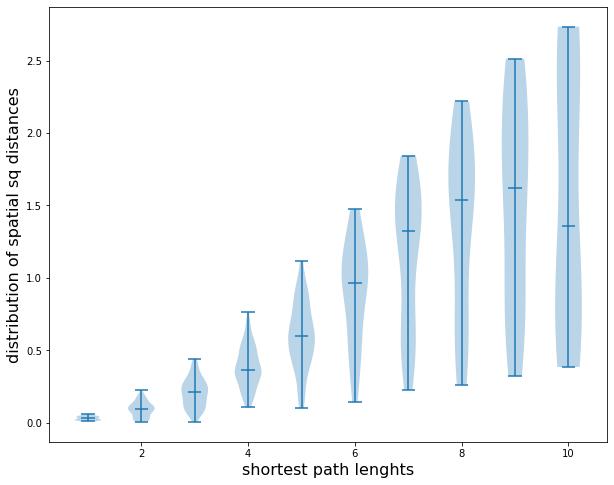

In [19]:
plt.figure(figsize=(10,8))
plt.violinplot(d_violin.values(), showmedians=True)
plt.xlabel('shortest path lenghts',fontsize = 16)
plt.ylabel('distribution of spatial sq distances',fontsize = 16)
plt.savefig('spl_xy_N1000.png')


In [20]:
l_medians = []
for k, v in d_violin.items():
    l_medians.append(statistics.median(v))
r = np.corrcoef(np.array(range(1,diameter)), np.array(l_medians))
print('Pearson correlation coefficient:', r[0][1])


Pearson correlation coefficient: 0.9566979218468713


In [102]:
#################################################################
#
#    Visiting probability based distances
#
##################################################################   

In [93]:
t0 = time.time()

r = .8
alpha = 1.
num_nodes = G.number_of_nodes()
A = nx.adjacency_matrix(G,sorted(G.nodes()))

#################################################################
#
#    INVERT MARKOV MATRIX & GENERATE RW MATRIX
#
###################

W = rnd_walk_matrix(A, r, alpha, num_nodes)

print('Inversion done')

#################################################################
#
#    GENERATE DICT FOR NODE-LABELS TO INTEGERS
#
###################

d_idx_entz = {}
cc = 0
for entz in sorted(G.nodes()):
    d_idx_entz[cc] = entz
    cc += 1
d_entz_idx = dict((y,x) for x,y in d_idx_entz.items())   


print('computing time: %.2f' %float(time.time()-t0))

Inversion done
computing time: 0.13


In [98]:
d_pvis = {}
for a,b in it.combinations(G.nodes(),2):
    idx_a = d_entz_idx[a]
    idx_b = d_entz_idx[b]
    # print(idx_a)
    # print()
    # print(W[idx_a,idx_b])
    p_d =  min((W[idx_a,idx_b],W[idx_b,idx_a]))
    d_pvis[(a,b)] = -np.log(p_d)


In [99]:
# l_stacked_xy = np.zeros(100)
d_violin_p = {}
for dd in range(1,diameter):
    l_s = []
    for k, v in d_spl.items():
        if v == dd:
            l_s.append(k)

    l_pvis = []
    for ab in l_s:
        try:
            dp = d_pvis[ab]
            l_pvis.append(dp)
            # print(ab,dxy)
        except:
            pass
    # l_stacked_xy = np.vstack((l_stacked_xy,l_xy))
    d_violin_p["string{0}".format(dd)] = l_pvis


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Text(0, 0.5, 'distribution of -log pvis distances')

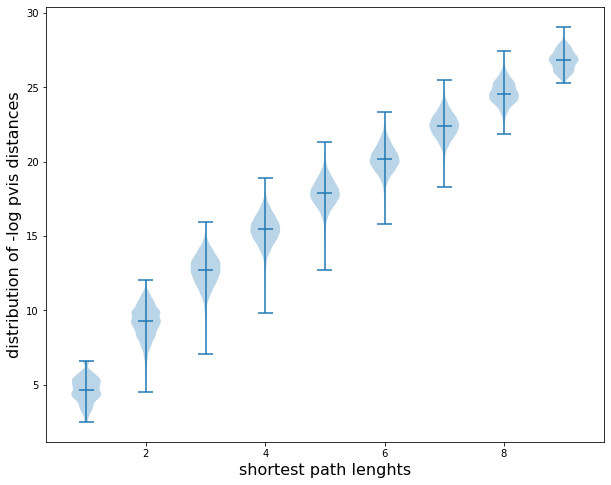

In [101]:
plt.figure(figsize=(10,8))
plt.violinplot(d_violin_p.values(), showmedians=True)
plt.xlabel('shortest path lenghts',fontsize = 16)
plt.ylabel('distribution of -log pvis distances',fontsize = 16)
# plt.savefig('spl_xy_N1000.png')


# --------------------------------------